# 3가지 모델 비교 실험

relevance, ensemble, mutiagent RAG 3가지 모델에 대해서 결과를 출력하고 Gound Truth를 가지고 평가진행.


In [1]:
import os
from dotenv import load_dotenv
from pprint import pprint

from langchain_teddynote import logging
from langchain_google_genai import ChatGoogleGenerativeAI

from graph_relevancerag import RelevanceRAG
from graph_ensemblerag import EnsembleRAG
from graph_multiagentrag import MultiAgentRAG
from utils import *

# .env 파일 로드
load_dotenv(dotenv_path=".env")

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# 프로젝트 이름을 입력합니다.
logging.langsmith("RAG 0204-Evaluation")

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG 0204-Evaluation


## eval

In [3]:
def get_rag_instance(
    rag_method, 
    file_folder, 
    file_number, 
    # db_folder,
    chunk_size, 
    chunk_overlap,
    search_k,
    system_prompt, 
    model_name,
    answer_model_name, 
    save_graph_png
):
    """
    RAG 클래스를 동적으로 받아서 인스턴스를 생성하는 함수
    
    Params:
        rag_method: RAG 방법 ("relevance-rag", "ensemble-rag", "multiagent-rag")
        file_folder: 논문 파일이 위치한 폴더 경로
        file_number: 처리할 논문 번호
        system_prompt: system prompt
        model_name: LLM 모델 명 ("gpt-4o", "gpt-4o-mini")
        save_graph_png: graph 저장 결정
        
    Return:
        생성된 RAG 모델 인스턴스
    """
    
    # RAG 모델 인스턴스 생성
    if rag_method == "relevance-rag":
        return RelevanceRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, answer_model_name, save_graph_png)
        
    elif rag_method == "ensemble-rag":
        return EnsembleRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "multiagent-rag":
        return MultiAgentRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)


def main(
    data_folder:str="/home/aiffel04/AIFFEL/VOLTAI/data/papers",
    file_num_list:list=[11],
    category_number:int=1, 
    chunk_size:int=500, 
    chunk_overlap:int=100, 
    search_k:int=10,       
    config_folder:str="./config",
    rag_method:str="multiagent-rag", 
    model_name:str="gpt-4o",
    answer_model_name:str="gpt-4o", 
    save_graph_png:bool=False, 
):
    category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]
    
    ## system_prompt 와 invoke_input 불러오기
    system_prompt = load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
    invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
    
    ## 각 논문에 대해 반복
    for i, file_number in enumerate(file_num_list):
        print(f"#####    {file_number}번째 논문    #####")
        print(f"##       rag method     : {rag_method}")
        print(f"##       category name  : {category_names[category_number-1]}")
        
        ## graph 호출
        voltai_graph = get_rag_instance(
            rag_method=rag_method, 
            file_folder=f"{data_folder}", 
            file_number=file_number, 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            system_prompt=system_prompt,
            model_name=model_name,
            answer_model_name=answer_model_name, 
            save_graph_png=save_graph_png,
        ).graph
        
        ## 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
        if isinstance(invoke_input, dict):
            
            result = voltai_graph.invoke(**invoke_input)
        else:
            result = voltai_graph.invoke(*invoke_input)

        ## RAG method에 따른 결과 확인
        if result.get("answer"):
            temp_answer = result["answer"][0][category_names[category_number-1]]
        elif result.get("discussion"):
            temp_answer = result["discussion"][category_names[category_number-1]]
        elif result.get("messages"):
            temp_answer = result["messages"][-1][category_names[category_number-1]]
        
        print(f"##       print {file_number} result")
        print("------------------------------------")
        pprint(temp_answer, sort_dicts=False)
        
        return temp_answer

def eval_df_generator_cat(
    file_folder="/home/aiffel04/AIFFEL/VOLTAI/data/papers",      ## input 논문이 있는 폴더 위치
    file_list=[11, 16, 22, 35, 39, 40, 41, 42, 44, 56, 64],            ## 아직 8번 논문 안됨
    category_number=1                     ## question 번호 1,2,3,4 중 하나
):
    print(f"🔍 실행 중: eval_df_generator_cat | file_list: {file_list}")  # 값 확인
    eval_df = pd.DataFrame(columns=["paper_number","type", "result","ground_truth"])
    
    types = ["relevance-rag"]
    for t in types: 
        df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])
        for i, file_number in enumerate(file_list):
            result= main(file_num_list=[file_number], category_number= category_number, rag_method=t, chunk_size=1000, answer_model_name="gpt-4o")
            ### result 저장
            ## gt 불러오기기
            if file_number < 10:
                file_name = f"paper_00{file_number}"
            elif file_number < 100:
                file_name = f"paper_0{file_number}"
            else:
                file_name = f"paper_{file_number}"
        
            # JSON 파일 경로
            file_path = f"./data/ground_truth/{file_name}_gt.json"

            # JSON 파일 읽기
            with open(file_path, "r", encoding="utf-8") as file:
                gt = json.load(file)

            ## df에 결과 저장하기       
            if category_number == 1:
                category_name = "CAM (Cathode Active Material)"
            elif category_number == 2:
                category_name = "Electrode (half-cell)"
            elif category_number == 3:
                category_name = "Morphological Properties"
            elif category_number == 4:
                category_name = "Cathode Performance"    
            else:
                raise
            print(f"🔍 gt[{category_name}] 타입:", type(gt[category_name]))
            print(f"🔍 gt[{category_name}] 값:", gt[category_name])
            df.loc[i, "paper_number"] = file_number
            df.loc[i, "type"] = t
            df.loc[i, "category_number"] = category_number
            df.loc[i, "category_name"] = category_name
            df.loc[i, "result"] = [result] 
            df.loc[i, "ground_truth"] = [gt[category_name]]
            
            ## [dict(key = category_name, value = gt[category_name])]
        eval_df = pd.concat([eval_df, df], ignore_index=True)    
    return eval_df



def concat_category_eval(
        f_list:list =[11, 16, 22, 35, 39, 40, 41, 42, 44, 56, 64]
):
    category  = [1,2,3,4]
    eval_df = pd.DataFrame(columns= ['paper_number', 'type', 'result', 'ground_truth', 'category_name',
       'category_number'])
    
    for i in category:
        df = eval_df_generator_cat(file_list= f_list, category_number=i)

        eval_df = pd.concat([eval_df, df])

    return eval_df



In [4]:
file_ = [11,16,22,35,39,40,41,42,44,56,64]
df = concat_category_eval(f_list =file_ )

🔍 실행 중: eval_df_generator_cat | file_list: [11, 16, 22, 35, 39, 40, 41, 42, 44, 56, 64]
##       ./config/relevance-rag/c1-system-prompt.yaml를 불러왔습니다.
##       ./config/relevance-rag/c1-question.yaml를 불러왔습니다.
#####    11번째 논문    #####
##       rag method     : relevance-rag
##       category name  : CAM (Cathode Active Material)
##       paper_011 retriever를 생성했습니다.
##          - chunk_size    :500
##          - chunk_overlap :100
##          - retrieve_k    :10


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'temperature' is not supported with this model.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_parameter'}}

In [4]:
df

,paper_number,type,result,ground_truth,category_name,category_number
0,11,relevance-rag,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NR0': {'Li ra...,CAM (Cathode Active Material),1.0
1,16,relevance-rag,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM': {'Li ra...,CAM (Cathode Active Material),1.0
2,22,relevance-rag,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'Pristine NCM'...,CAM (Cathode Active Material),1.0
3,35,relevance-rag,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'S1bare': {'Li...,CAM (Cathode Active Material),1.0
4,39,relevance-rag,[{'Stoichiometry information': {'N92': {'Li ra...,[{'Stoichiometry information': {'N92': {'Li ra...,CAM (Cathode Active Material),1.0
5,40,relevance-rag,[{'Stoichiometry information': {'SC-NCM83': {'...,[{'Stoichiometry information': {'SC-NCM83': {'...,CAM (Cathode Active Material),1.0
6,41,relevance-rag,[{'Stoichiometry information': {'NCM-811': {'L...,[{'Stoichiometry information': {'NCM-811': {'L...,CAM (Cathode Active Material),1.0
7,42,relevance-rag,[{'Stoichiometry information': {'SC-NCM': {'Li...,[{'Stoichiometry information': {'SC-NCM': {'Li...,CAM (Cathode Active Material),1.0
8,44,relevance-rag,[{'Stoichiometry information': {'NCM-622': {'L...,[{'Stoichiometry information': {'pristine NCM6...,CAM (Cathode Active Material),1.0
9,56,relevance-rag,[{'Stoichiometry information': {'LiNi0.8Co0.1M...,[{'Stoichiometry information': {'pristine NCM'...,CAM (Cathode Active Material),1.0


In [5]:
df.to_csv("eval.csv", index=False)

df = pd.read_csv("eval.csv")

In [6]:
def eval_sentence_generator(category_number, result_dict):
    if category_number == 1:
        values = list(result_dict.values())
        return f"The {values} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating."
    
    elif category_number == 2:
        values = list(result_dict.values())
        return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]}."
    
    elif category_number == 3:
        values = list(result_dict.values())
        return f"Particle size is {values[0]}, Particle shape is {values[1]} and Particle distribution is {values[2]}. Also Coating layer characteristics are {values[3]}. Crystal structure and lattice characteristics are {values[4]}."
    
    elif category_number == 4:
        s = ""
        for k, v in result_dict.items():
            for i in range(len(v)):
                s += f"C-rate and Specific capacity of {k} in {v[i]['Voltage range']} voltage range and {v[i]['Temperature']} temperature is {v[i]['C-rate and Specific capacity']}."
        return s

In [7]:
import ast
# result_sentence와 ground_truth_sentence 리스트 생성
result_sentences = []
ground_truth_sentences = []

for _, row in df.iterrows():
    category_number = int(row['category_number'])
    result_dict = ast.literal_eval(row['result'])[0]
    ground_truth_dict = ast.literal_eval(row['ground_truth'])[0]
    
    result_sentences.append(eval_sentence_generator(category_number, result_dict))
    ground_truth_sentences.append(eval_sentence_generator(category_number, ground_truth_dict))

# 새로운 열 추가
df['result_sentence'] = result_sentences
df['ground_truth_sentence'] = ground_truth_sentences

In [8]:
df.to_csv("eval_sentence.csv", index=False)

## Scoring

In [9]:
from metrics.metric_eval import evaluate_all_metrics
import pandas as pd
df1 = pd.read_csv('eval_sentence.csv')

[nltk_data] Downloading package wordnet to /home/aiffel04/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
## 모든 metric data frame
metric_df = df1[["ground_truth_sentence", "result_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["result_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
rouge_df = metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
df = pd.concat([df1, metric_df.drop(columns=["ROUGE"]), rouge_df], axis=1)

In [11]:
# 필요한 라이브러리 다시 설치 및 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_comparisons(df):
    metrics = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']
    custom_colors = ["#004823", "#007200", "#38B000", "#70E000", "#9EF01A", "#CCFF33"]
    
    # Type별 점수 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='type', y='Score', hue='Metric', palette=custom_colors)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

    # category_number별 + type별 점수 평균 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['category_number', 'type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['category_number', 'type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='category_number', y='Score', hue='Metric', palette=custom_colors)


    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

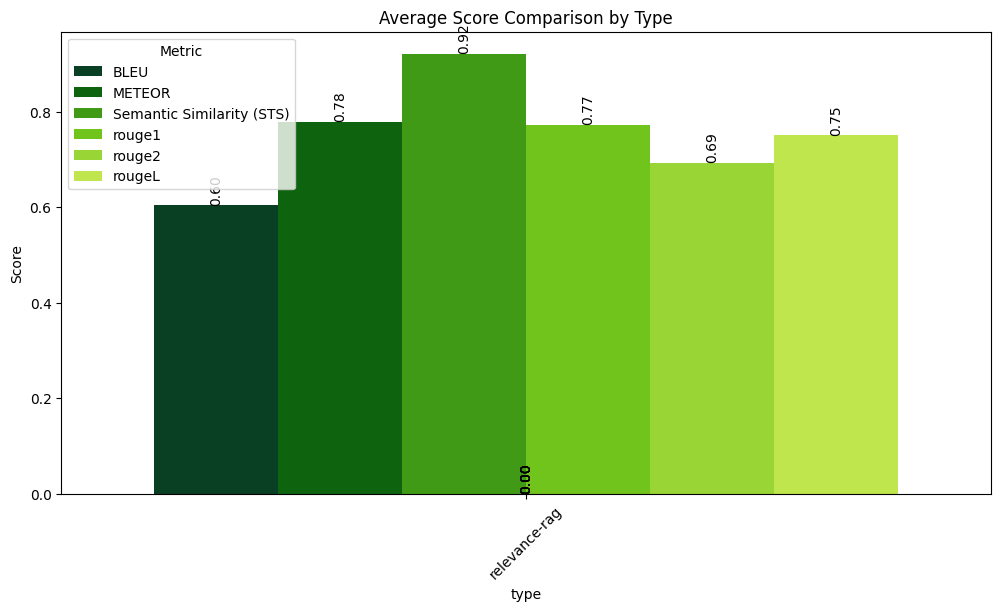

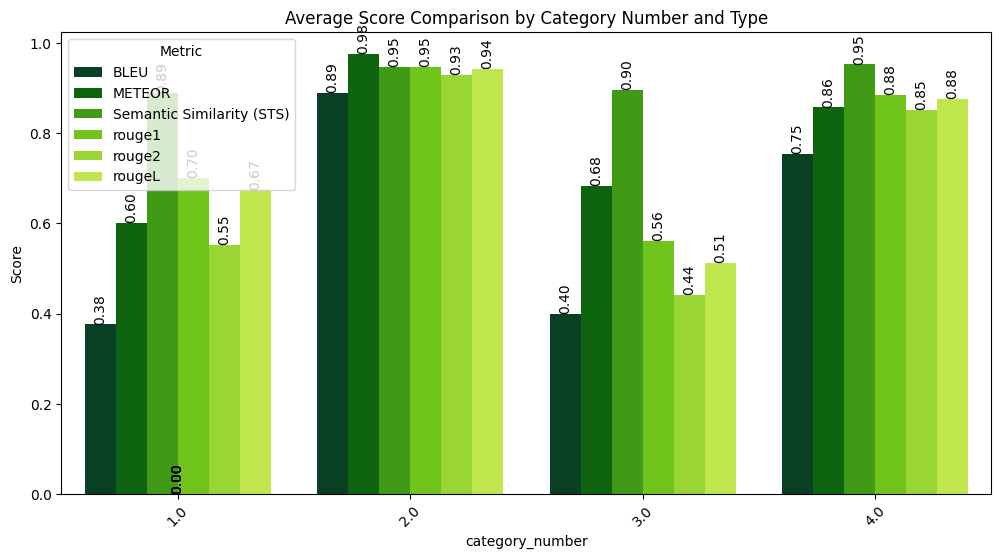

In [12]:
plot_score_comparisons(df)

## evalutaion notebook codes
임의로 문장 템플릿을 생성하여 llm answer의 value들을 넣어서 만든 문장을 비교하여 평가하는 코드입니다.  
`question1` 과 `question2`에 대해서만 진행했습니다.  
`question3` 와 `questino4`의 경우 수정될 수 있어 추후 진행하겠습니다. (금방할 수 있습니다)  

In [13]:
df.to_csv("score.csv",index=False)